## Analyzing Borehole Lifespan

This notebook provides an example of how to analyze the lifespan of water wells (boreholes) using survival analysis techniques.

We use the Python package **lifelines** for survival analysis (documentation: https://lifelines.readthedocs.io).

In this example, we use a global anonymized dataset (see Electronic supplementary material **EMS 1**), but this notebook can be used to analyze any dataset. To ensure meaningful and representative results, the analysis should be based on a complete dataset that includes both commissioning and decommissioning dates for boreholes.Partial datasets may lead to biased estimates of borehole lifespan.






In [ ]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import norm, lognorm 
from scipy.stats import truncnorm
from scipy.optimize import minimize

# Lifelines imports (https://pypi.org/project/lifelines/)
from lifelines import KaplanMeierFitter 

# Personalized code for the analysis 
import ESM3 as BoreholesLifespan

# 1 Load the dataset 

First, import the data file and rename the columns as defined in the code.

The dataset should contain at least the following information: 

* Last update year : Year of the last update or inspection of the borehole, for boreholes that are still in use
    
* Construction year : Year the borehole was constructed/comissionned 
    
* Year of decommissioning : Year the borehole was decommissioned (NA if still operating, 9999 if unknown) 

If known, pumping rate information and any explanatory variables can be added. In this example, we include:
 
    
* Nominal pumping rate (m3/s)  : Nominal pumping rate (m³/s), for regular operation
    
* Last pumping rate (m3/s)  : Last (Most recent) recorded pumping rate (m³/s)

* Total depth (m) : Total depth of the borehole in meters

In [5]:
# Import your datafile
data =  pd.read_excel('01_Data/GlobalDataset.xlsx') 

# Rename the columns with the name of the variables as: 
data.rename(columns={  
    'Last update year': 'CheckDate',  # Year of the last update or inspection of the borehole
    'Borehole ID': 'BoreholeID',      # Unique identifier for the borehole
    'Construction year': 'ComDate',   # Year the borehole was constructed/comissionned 
    'Total depth (m)':'Depth',        # Total depth of the borehole in meters
    'Nominal pumping rate (m3/s)': 'QAnnual', # Nominal pumping rate (m³/s), for regular operation
    'Last pumping rate (m3/s)': 'QFinal',    # Last (Most recent) recorded pumping rate (m³/s)
    'Year of decommissioning (NA for boreholes in operation, 9999 for unknown)': 'DecomDate'   # Year the borehole was decommissioned (NA if still operating, 9999 if unknown) 
}, inplace=True)

# 2 Prepapre the variables

To apply the analysis, two variables are needed:

* The `time` variable, which corresponds to the survival time — that is, the time elapsed between the borehole's commissioning and decommissioning.

* The `status` variable, which indicates whether the borehole is still in use (0 = censored) or has been decommissioned (1 = event).

The second step consists of defining these variables.


In [6]:
# Information on the data 
total_count = data.shape[0]
decom_count = data['DecomDate'].count()
percentage_decom = (decom_count * 100) / total_count if total_count > 0 else 0

print('Total number of boreholes:', total_count)
print('Percentage of decommissioned data:', round(percentage_decom, 2), '%')

Total number of boreholes: 1599
Percentage of decommissioned data: 31.64 %


In [7]:
# Create the `time` and `status` variables
data['FinalDate'] = np.where(data['DecomDate'].notna(), data['DecomDate'],data['CheckDate']) # In some cases, we may know that a borehole was still in use up to a specific date (Check date) prior to 2025.
data['time'] = data['FinalDate']- data['ComDate']
data['status'] = data['DecomDate'].notna().astype(int)
# For boreholes with missing decommissioning dates, we simulated values using the normal distribution fitted to the known decommissioning dates. 
data_no9999 = data[data['DecomDate'] != 9999.].copy()
#data_no9999 = data_no9999.dropna(subset=['DecomDate'])
mu_world, std_world = np.mean(data_no9999['DecomDate']), np.std(data_no9999['DecomDate'])
max_val = 2024
seed = 42
np.random.seed(seed)
mask_d = data['DecomDate'] == 9999 
BoreholesLifespan.simul_decom(data, mask_d, mu_world, std_world, max_val) # Simulate decommissioning dates and assign them to cases where they are not known

In [8]:
# Clean and update the variables
data['FinalDate'] = np.where(data['DecomDate'].notna(), data['DecomDate'],data['CheckDate'])
data['time'] = data['FinalDate']- data['ComDate']  # Recalculate the time variable
data['DiffQ'] = data['QAnnual'] - data['QFinal']   # Calculate the difference in yield                           
data['DimQ'] = (data['DiffQ'] / data['QAnnual'])*100 # in percent 
data['time'] = data.apply(BoreholesLifespan.adjust_time, axis=1) # Adjust time as a function of yield reduction.
data['status'] = data['DecomDate'].notna().astype(int) # redefine the status: (0 = censored, still in use), (1 = event, decommisionned)  
data = BoreholesLifespan.clean_time_column(data, column_name="time", small_value=0.01) # Clean the "time" column. 

Negative values found in the 'time' column. Replacing them with 0.
There are zero values in the 'time' column.
Zero values were replaced by 0.01.
There are no NA values in the 'time' column.


## 3 Apply the analysis to the global dataset

We use the Kaplan-Meier estimator to describe the survival function of the boreholes.  
We then model the survival curve and extend it up to 60 years, if needed, using the Gompertz model.  
Finally, the lifespan is defined as the Restricted Mean Survival Time (RMST) of the Gompertz model up to 60 years.
See the paper for more info.


In [9]:
# Define the Kaplan-Meier estimator
T_tot = data["time"]  # Survival time of the boreholes
E_tot = data["status"]  # Indicates whether the borehole is decommissioned (1) or still in use (0 — censored)

timeline = np.linspace(0, max(T_tot), 60)

kmf_tot = KaplanMeierFitter()  # Initialize the Kaplan-Meier estimator with censored data
kmf_tot.fit(T_tot, E_tot, timeline=timeline)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1599 total observations, 1093 right-censored observations>

In [10]:
initial_guess = [1.0, 0.01]  # Define initial parameter values for the Gompertz model: [alpha, lambda]
# Fit the Gompertz model by minimizing the negative log-likelihood
res_gompertz = minimize(
    BoreholesLifespan.neg_log_likelihood_gompertz,
    x0=initial_guess,
    args=(T_tot, E_tot),
    bounds=[(1e-5, None), (1e-5, None)]
)
alpha_hat, lambda_hat = res_gompertz.x # Extract estimated parameters from the fitted model
cov_matrix = res_gompertz.hess_inv.todense() # Compute the covariance of the estimated parameters
x_grid = np.linspace(0, 60, 60)
S_gompertz = BoreholesLifespan.gompertz_survival_function(x_grid, alpha_hat, lambda_hat) # Compute the Gompertz survival function using the estimated parameters
ci_lower, ci_upper = BoreholesLifespan.confidence_interval_gompertz(x_grid, alpha_hat, lambda_hat, cov_matrix) # Compute the 95% confidence interval for the Gompertz survival function

## 3.1 Plot the results

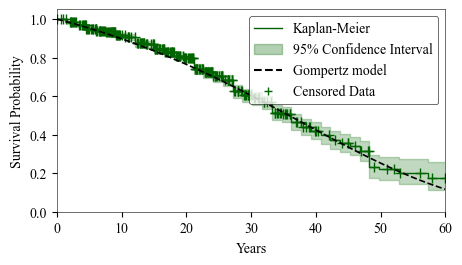

In [11]:
# Plot the survival functions 

BoreholesLifespan.plot_survival_function(
    kmf_fit=kmf_tot,
    legend_label='Kaplan-Meier',
    color='darkgreen',
    fig_width_cm=12,
    fig_height_cm=7,
    xlim=60,
    show_censors=True, # display or not the censored data (boreholes that are still in use)
    ci_show=True, # show confidence interval of the Kaplan-Meier function
    legend_loc='upper right',
    show_gompertz=True, # display or not the Gompertz model 
    x_grid=x_grid,
    S_gompertz=S_gompertz,
    ci_lower=ci_lower,
    ci_upper=ci_upper,
    output_path=None
)

## 3.2 RMST VALUES 

In [12]:
# Compute RMST (Restricted Mean Survival Time) using the Gompertz model
km_times = kmf_tot.survival_function_.index.values  # Time points from the Kaplan-Meier curve

# Estimate RMST from the Gompertz survival function up to 60 years
rmst_gompertz = BoreholesLifespan.gompertz_rmst(60, alpha_hat, lambda_hat)

# Estimate 95% confidence interval for RMST
res = BoreholesLifespan.calcul_rmst_gompertz_ci(T_tot, E_tot, time_limit=60, n_bootstraps=100)

# Display the RMST and its uncertainty 
print(f"RMST from Gompertz model at 60 years: {res['RMST']:.2f} ± {res['±']:.2f} years")

RMST from Gompertz model at 60 years: 35.02 ± 1.61 years


# 4 Analyze the lifespan by group

In this part, the data are grouped into categories and analyzed to compare borehole lifespan across different factors. 

Here, for the example, boreholes are grouped based on annual production yield. However, other variables — such as depth — can also be analyzed by adjusting the variable names. The classification is based on threshold values, and boreholes are categorized accordingly in order to compare their RMST.

## 4.1 Analyze the yield: 

In [13]:
data = data.dropna(subset=['QAnnual']) # Remove rows where the nominal yield (QAnnual) is missing
data.loc[:, 'QAnnual'] = pd.to_numeric(data['QAnnual'], errors='coerce')

# Function to categorize nominal yield into two groups
def assign_value_yield(x):
    if 0 <= x <= 0.00555556:
        return 'Yield < 20 m$^3$/h'
    elif x > 0.00555556:
        return 'Yield > 20 m$^3$/h'

# Apply the categorization to the 'QAnnual' column
data['QAnnual'] = data['QAnnual'].apply(assign_value_yield)

data = data.dropna(subset=['QAnnual'])  # Remove rows where 'QAnnual' is NaN (i.e., yield is missing or invalid)

In [14]:
# Create separate time (T1) and event (E1) variables for each yield category

T_per_yield, E_per_yield = BoreholesLifespan.TandE_pervariable(data, group_var= 'QAnnual', time_var='time', status_var='status') # 'group_var' refers to the name of the column you grouped the data by

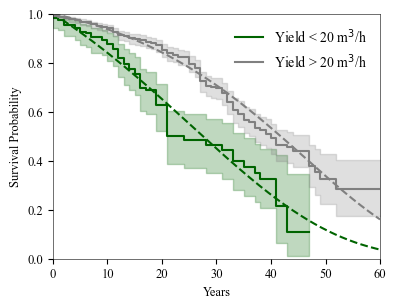


RMST estimates with 95% CI:

Yield < 20 m$^3$/h: RMST = 28.31 ± 4.29 
Yield > 20 m$^3$/h: RMST = 39.45 ± 2.14 


In [ ]:
# Plot the survival functions and the RMST results per groups of variable

rmst_results = BoreholesLifespan.plot_results_per_group(
    T1_par_variable = T_per_yield,
    E1_par_variable = E_per_yield,
    tmax=60,
    n_bootstraps=150,
    legend_loc='upper right',
    fig_width_cm=10.32 , fig_height_cm=8.1 ,
    output_path= None 
)